# Saving Lompe Output and replotting
1. create model as usual
2. run the saving model code
3. reload the model using the load_model class
4. treat the same as lompe model object


### import necessary functions

In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import apexpy
import lompe

# 1. Create model as usual
### Select time and initalise apexpy

In [5]:
# select time:
time = dt.datetime(2012, 4, 5, 17, 0)
apex = apexpy.Apex(time.year, refh = 110)
DT = dt.timedelta(seconds = 1 * 60) # will select data from time +- DT

### Set up cubedsphere grid

In [6]:
position = (-90, 68.1) # lon, lat
f1, f2 = apex.basevectors_qd(position[1], position[0], 0, coords = 'geo')
qd_north = f2 / np.linalg.norm(f2)
# set up grid
position = (-90, 75) # lon, lat
orientation = (-1, 2) # east, north
L, W, Lres, Wres = 4000e3, 6000e3, 100.e3, 100.e3 # dimensions and resolution of grid (L, Lres are along orientation vector)
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, Lres, Wres, R = 6481.2e3)

### Load sample datasets

In [7]:
event ='2012-04-05'
# sample datasets
supermagfn = './sample_dataset/20120405_supermag.h5'
superdarnfn = './sample_dataset/20120405_superdarn_grdmap.h5'
iridiumfn = './sample_dataset/20120405_iridium.h5'


# load ampere, supermag, and superdarn data from 2012-04-05
ampere    = pd.read_hdf(iridiumfn)
supermag  = pd.read_hdf(supermagfn)
superdarn = pd.read_hdf(superdarnfn)

### Get model conductance

In [12]:
Kp = 4 # for Hardy conductance model

SH = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, time, 'hall', starlight = 1e-1)
SP = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, time, 'pedersen', starlight = 1e-1)

### Run electric field model

In [15]:
# ELECTRIC FIELD MODEL

# 1) Prepare datasets

# prepare ampere
amp = ampere[(ampere.time >= time - DT) & (ampere.time <= time + DT)].dropna()
B = np.vstack((amp.B_e.values, amp.B_n.values, amp.B_r.values))
coords = np.vstack((amp.lon.values, amp.lat.values, amp.r.values))
# Lompe data object
amp_data = lompe.Data(B * 1e-9, coords, datatype = 'space_mag_fac', scale = 200e-9)

# prepare supermag
sm = supermag[time-DT:time+DT].dropna()
B = np.vstack((sm.Be.values, sm.Bn.values, sm.Bu.values))
coords = np.vstack((sm.lon.values, sm.lat.values))
sm_data = lompe.Data(B * 1e-9, coords, datatype = 'ground_mag', scale = 100e-9)

# prepare superdarn
sd = superdarn.loc[(superdarn.index >= time - DT) & (superdarn.index <= time+ DT)].dropna()
vlos = sd['vlos'].values
coords = np.vstack((sd['glon'].values, sd['glat'].values))
los  = np.vstack((sd['le'].values, sd['ln'].values))
sd_data = lompe.Data(vlos, coordinates = coords, LOS = los, datatype = 'convection', scale = 500)

# 2) Initialize model and add datasets, and run inversion

emod = lompe.Emodel(grid, (SH, SP))
emod.add_data(amp_data, sm_data, sd_data)
emod.run_inversion(l1 = 2, l2 = 0);

### Plot the model

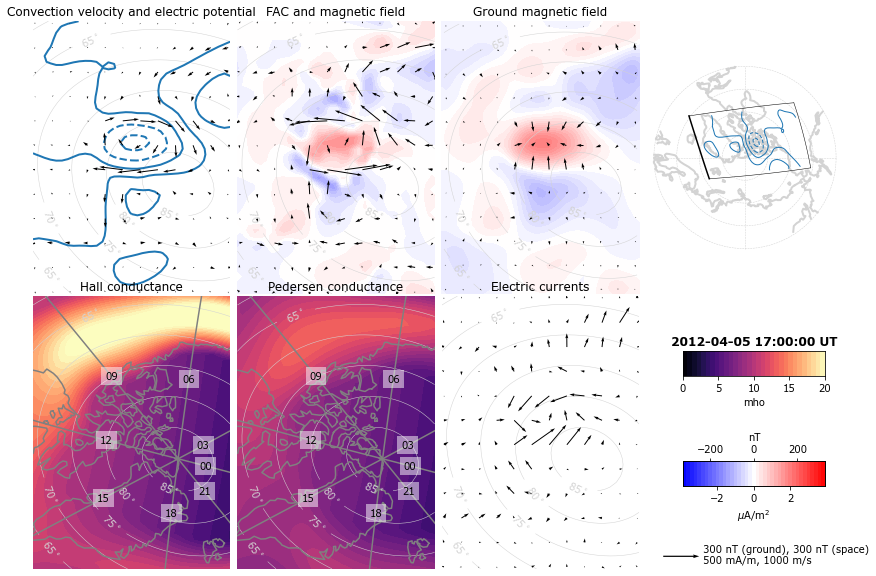

In [16]:
fig_axes = lompe.lompeplot(emod, include_data = False, time = time, apex = apex, return_axes=True)

# 2. Run the saving model code
### Currently specify the time for the model and folder with a prefix for the where the model should be saved

In [17]:
emod.save_output(time, path='./', overwrite = True)

AttributeError: 'Emodel' object has no attribute 'save_output'

- When a path is specified the model is saved into two xarrays with one having the cubed sphere grid properties as attritbutes and the other having cubed sphere projection properties as attributes. The two files are needed as they are saved on the two different default grids
- The two xarrays are also returned
- When no path is specified the xarrays are just returned and a dictionary containing the properites for recreating the cubed sphere grid object

# 3. Reload the model using the load_model class

In [19]:
from lompe.model.save_model import load_model

Specify time, Apex object for magnetic coordinates and load a saved model:

In [ ]:
time = dt.datetime(2012, 4, 5, 17, 0)
apex = apexpy.Apex(time.year, refh = 110)
emod2= load_model('./') # just need to specify the path

# 4. Treat the same as a Lompe model object

The load_model object can be treated the same as the Lompe model object when plotting. It is important to specify from_save=True as there are certain differences and currently there is no original data in the object so include_data=False

Loading from save model kwargs: ['lon', 'lat'] are unused
-12.649967262980084 12.649967262980084
Loading from save model kwargs: ['lon', 'lat'] are unused
Loading from save model kwargs: ['lon', 'lat'] are unused
Loading from save model kwargs: ['lon', 'lat'] are unused


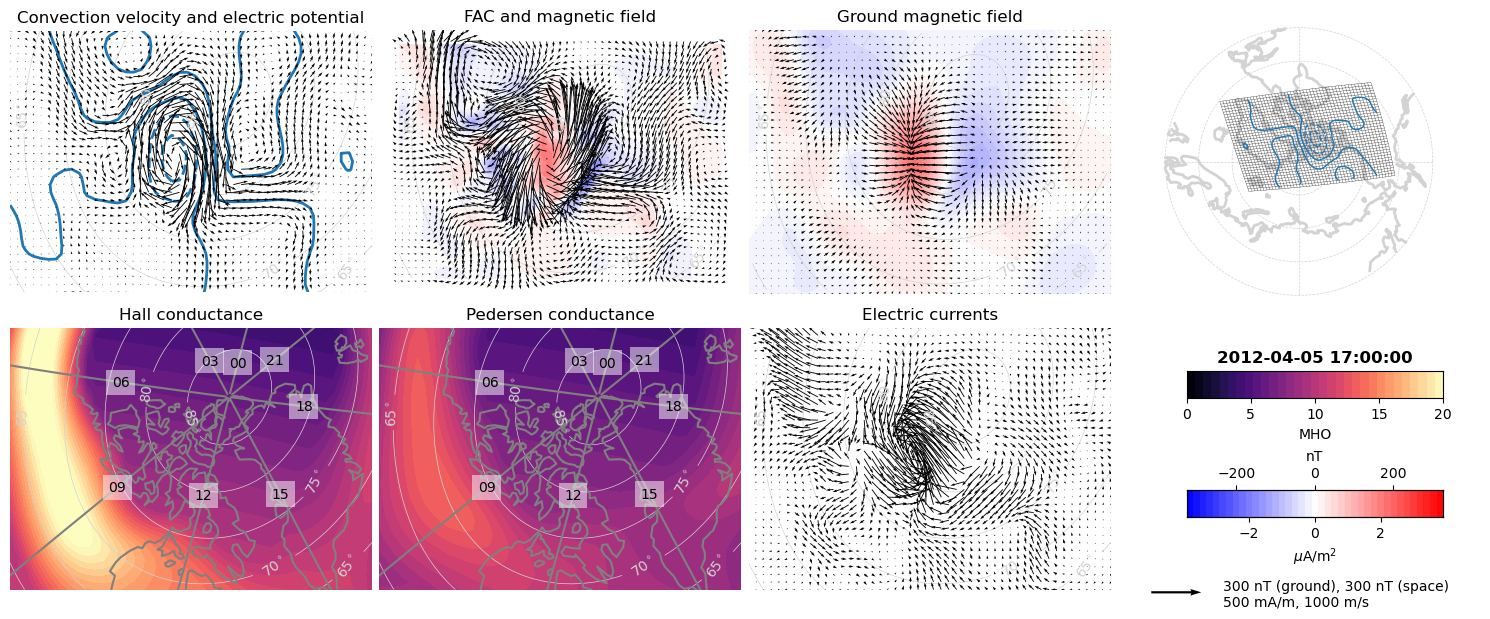

In [10]:
fig_axes = lompe.lompeplot(emod2, include_data = False, time = time, apex = apex, return_axes=True, from_save=True)